### Imports

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from scipy.stats import friedmanchisquare

### Data loading

In [ ]:
with open('../data/model_results.pkl', 'rb') as f:
    all_results = pickle.load(f)

print(f"Loaded results for: {list(all_results.keys())}")

### Model comparison


                        FINAL MODEL COMPARISON
              Model      Accuracy    F1 (macro) Recall (macro) AUC-ROC Avg Precision
Logistic Regression 0.682 ± 0.076 0.633 ± 0.084  0.645 ± 0.087   0.703         0.506
        DNN (Keras) 0.653 ± 0.143 0.626 ± 0.131  0.687 ± 0.073   0.663         0.511
      Random Forest 0.722 ± 0.089 0.629 ± 0.101  0.624 ± 0.092   0.699         0.553
      SVM (sigmoid) 0.693 ± 0.079 0.659 ± 0.083  0.682 ± 0.085   0.717         0.470
            XGBoost 0.722 ± 0.033 0.627 ± 0.065  0.631 ± 0.062   0.641         0.478


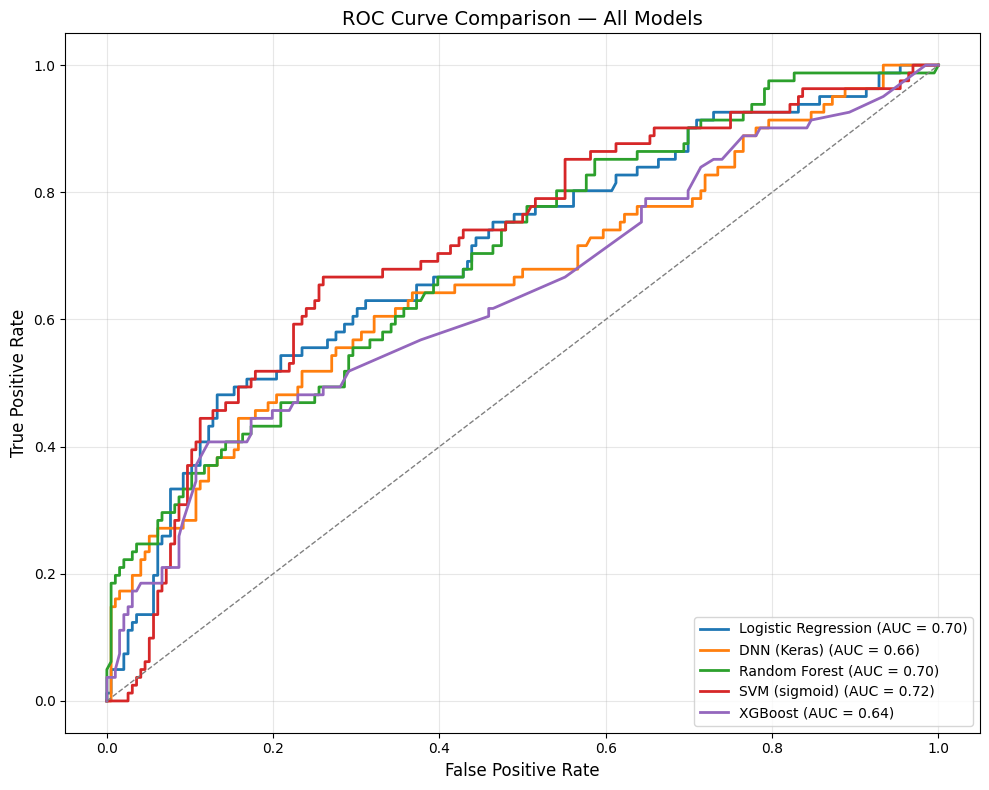

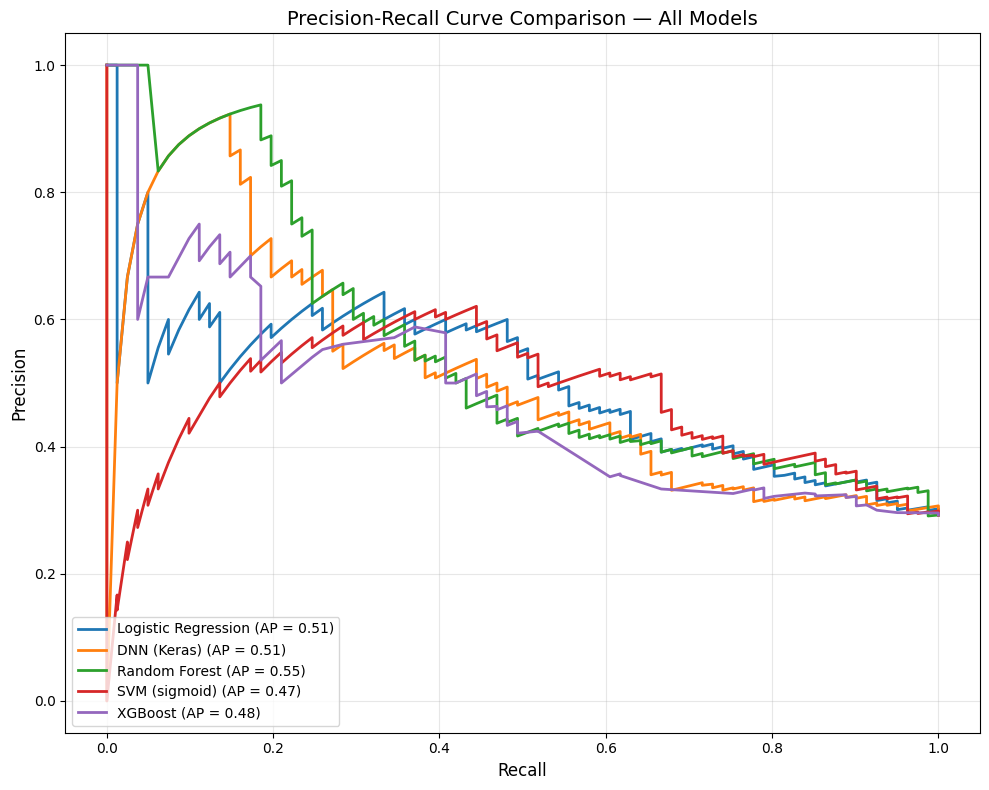

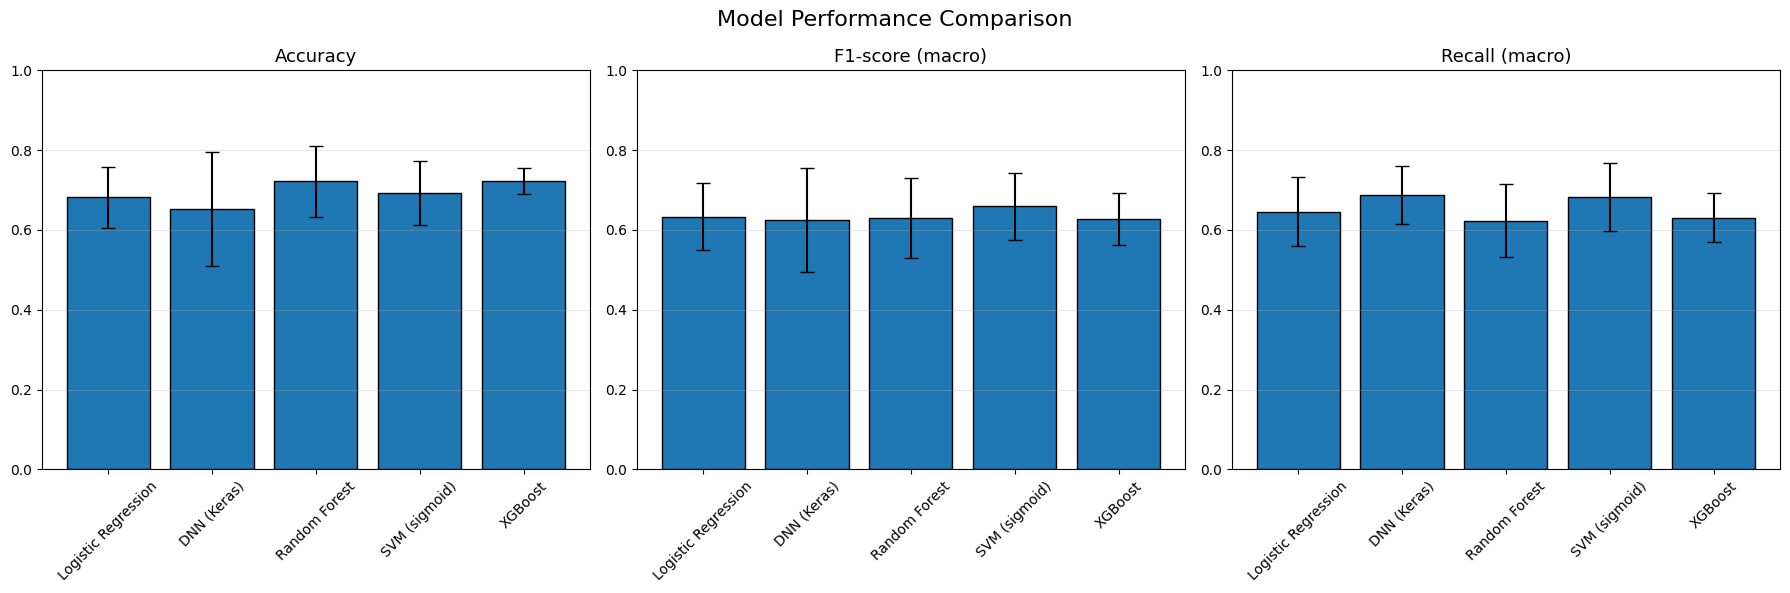

In [ ]:
all_results = {
    'Logistic Regression': {
        'metrics': lr_metrics, 'y_true': lr_y_true_all, 'y_proba': lr_y_proba_all
    },
    'DNN (Keras)': {
        'metrics': dnn_metrics, 'y_true': dnn_y_true_all, 'y_proba': dnn_y_proba_all
    },
    'Random Forest': {
        'metrics': rf_metrics, 'y_true': rf_y_true_all, 'y_proba': rf_y_proba_all
    },
    'SVM (sigmoid)': {
        'metrics': svm_metrics, 'y_true': svm_y_true_all, 'y_proba': svm_y_proba_all
    },
    'XGBoost': {
        'metrics': xgb_metrics, 'y_true': xgb_y_true_all, 'y_proba': xgb_y_proba_all
    }
}

# Tabella comparativa
comparison_rows = []
for name, res in all_results.items():
    df_m = pd.DataFrame(res['metrics'])
    fpr_c, tpr_c, _ = roc_curve(res['y_true'], res['y_proba'])
    auc_val = auc(fpr_c, tpr_c)
    ap_val = average_precision_score(res['y_true'], res['y_proba'])

    comparison_rows.append({
        'Model': name,
        'Accuracy': f"{df_m['Accuracy'].mean():.3f} ± {df_m['Accuracy'].std():.3f}",
        'F1 (macro)': f"{df_m['F1-score (macro)'].mean():.3f} ± {df_m['F1-score (macro)'].std():.3f}",
        'Recall (macro)': f"{df_m['Recall (macro)'].mean():.3f} ± {df_m['Recall (macro)'].std():.3f}",
        'AUC-ROC': f"{auc_val:.3f}",
        'Avg Precision': f"{ap_val:.3f}"
    })

df_comparison = pd.DataFrame(comparison_rows)

print('\n' + '=' * 80)
print('                        FINAL MODEL COMPARISON')
print('=' * 80)
print(df_comparison.to_string(index=False))

# ROC Curves sovrapposte
plt.figure(figsize=(10, 8))
for name, res in all_results.items():
    fpr_c, tpr_c, _ = roc_curve(res['y_true'], res['y_proba'])
    auc_val = auc(fpr_c, tpr_c)
    plt.plot(fpr_c, tpr_c, label=f'{name} (AUC = {auc_val:.2f})', lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - all Models', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-Recall curves sovrapposte
plt.figure(figsize=(10, 8))
for name, res in all_results.items():
    prec_vals, rec_vals, _ = precision_recall_curve(res['y_true'], res['y_proba'])
    ap_val = average_precision_score(res['y_true'], res['y_proba'])
    plt.plot(rec_vals, prec_vals, label=f'{name} (AP = {ap_val:.2f})', lw=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve Comparison - All Models', fontsize=14)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Bar chart comparativo
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metric_names = ['Accuracy', 'F1-score (macro)', 'Recall (macro)']

for idx, metric_name in enumerate(metric_names):
    model_names = []
    means = []
    stds = []
    for name, res in all_results.items():
        df_m = pd.DataFrame(res['metrics'])
        model_names.append(name)
        means.append(df_m[metric_name].mean())
        stds.append(df_m[metric_name].std())

    bars = axes[idx].bar(model_names, means, yerr=stds, capsize=5,
                          edgecolor='black')
    axes[idx].set_title(metric_name, fontsize=13)
    axes[idx].set_ylim(0, 1)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Model Performance Comparison', fontsize=16)
plt.tight_layout()
plt.show()

### Statistical tests

In [ ]:
f1_per_model = {}
for name, res in all_results.items():
    df_m = pd.DataFrame(res['metrics'])
    f1_per_model[name] = df_m['F1-score (macro)'].values

print('\nF1-score (macro) per fold per model:')
f1_df = pd.DataFrame(f1_per_model)
print(f1_df.to_string(index=True))

stat, p_value = friedmanchisquare(*f1_per_model.values())
print(f'\nFriedman Test')
print(f'Statistic: {stat:.4f}')
print(f'p-value: {p_value:.4f}')

if p_value < 0.05:
    print('-> Significant difference between models (p < 0.05)')
else:
    print('-> No significant difference between models (p >= 0.05)')


F1-score (macro) per fold per model:
   Logistic Regression  DNN (Keras)  Random Forest  SVM (sigmoid)   XGBoost
0             0.562500     0.326203       0.508772       0.672515  0.672515
1             0.650000     0.704374       0.717172       0.704374  0.604040
2             0.625668     0.674839       0.590244       0.733333  0.619048
3             0.590643     0.667984       0.549195       0.590643  0.619048
4             0.657143     0.714286       0.772358       0.594203  0.737500
5             0.788839     0.721195       0.809524       0.688889  0.650000
6             0.737500     0.594203       0.604040       0.788839  0.604040
7             0.584615     0.625000       0.571429       0.527822  0.486258
8             0.634586     0.746717       0.584615       0.715789  0.666667
9             0.500000     0.480769       0.584615       0.571429  0.614286

Friedman Test
Statistic: 0.6122
p-value: 0.9617
-> No significant difference between models (p >= 0.05)
